# Semestral project 1

In [1]:
# Group representative - Rafael Galiev 16.04.2003
K = 16
L = 6
M = ((K+L)*47)%%(11)+1
M

[1] 1

Česká republika!

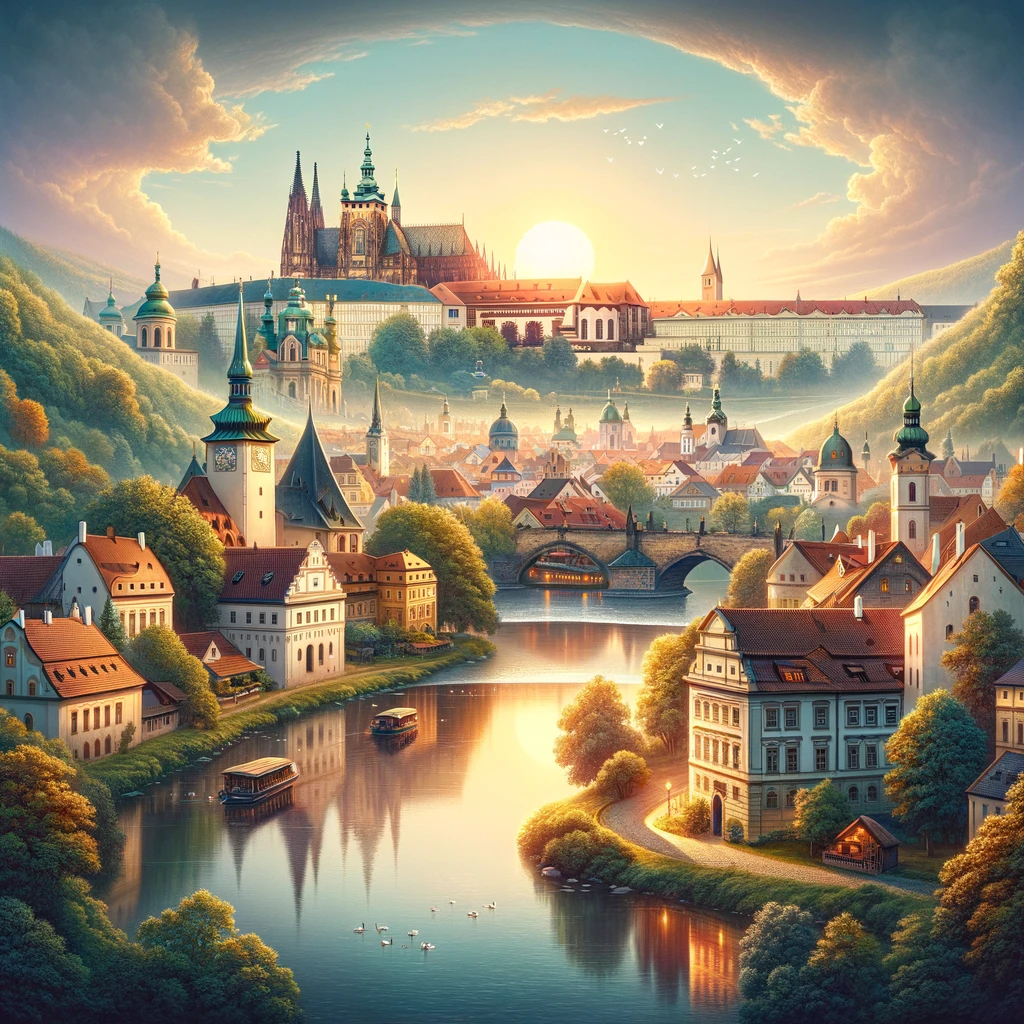

In [2]:
library(IRdisplay)
display_jpeg(file="./cze.webp")
# we asked gpt chat how would he represent the Czech Republic.

# Dataset preparation

In [3]:
library(eurostat)
library(vtable)
library(ggplot2)

Loading required package: kableExtra



In [4]:
search <- search_eurostat(pattern = "Police-recorded offences by NUTS 3 regions")
search

title,code,type,last.update.of.data,last.table.structure.change,data.start,data.end,values,hierarchy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Police-recorded offences by NUTS 3 regions,crim_gen_reg,dataset,05.12.2023,05.12.2023,2008,2021,216947,4
Police-recorded offences by NUTS 3 regions,crim_gen_reg,dataset,05.12.2023,05.12.2023,2008,2021,216947,4


In [5]:
code <- "crim_gen_reg"
df <- get_eurostat(id = code)

Table crim_gen_reg cached at /tmp/RtmpVySwoN/eurostat/9ac864b516df52315ea084dcece6e0fc.rds



In [6]:
head(df)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82
A,NR,ICCS0101,AL,2010-01-01,118
A,NR,ICCS0101,AL,2011-01-01,124
A,NR,ICCS0101,AL,2012-01-01,126
A,NR,ICCS0101,AL,2013-01-01,107


In [7]:
# get only the data for the Czech Republic
df_cz <- df[grepl("CZ", df$geo),]
# Keep only rows with NUTS level 3 and overall national data, excluding NUTS level 2 data
df_cz <- df_cz[grepl("^CZ0\\d{2}$", df_cz$geo), ]
head(df_cz)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,CZ010,2018-01-01,17
A,NR,ICCS0101,CZ010,2019-01-01,14
A,NR,ICCS0101,CZ010,2020-01-01,10
A,NR,ICCS0101,CZ010,2021-01-01,7
A,NR,ICCS0101,CZ020,2018-01-01,17
A,NR,ICCS0101,CZ020,2019-01-01,10


In [8]:
df_cz_2021 <- df_cz[format.Date(df_cz$TIME_PERIOD, "%Y") == "2021",]
df_cz_2021 <- label_eurostat(df_cz_2021, fix_duplicated = TRUE)
head(df_cz_2021)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
Annual,Number,Intentional homicide,Hlavní město Praha,2021-01-01,7
Annual,Number,Intentional homicide,Středočeský kraj,2021-01-01,1
Annual,Number,Intentional homicide,Jihočeský kraj,2021-01-01,7
Annual,Number,Intentional homicide,Plzeňský kraj,2021-01-01,2
Annual,Number,Intentional homicide,Karlovarský kraj,2021-01-01,3
Annual,Number,Intentional homicide,Ústecký kraj,2021-01-01,5


In [9]:
unique(df_cz_2021$freq)

[1] "Annual"

In [10]:
unique(df_cz_2021$TIME_PERIOD)

[1] "2021-01-01"

In [11]:
unique(df_cz_2021$iccs)

[1] "Intentional homicide"                    
[2] "Assault"                                 
[3] "Robbery"                                 
[4] "Burglary"                                
[5] "Burglary of private residential premises"
[6] "Theft"                                   
[7] "Theft of a motorized land vehicle"

In [12]:
# Delete 'freq' and 'TIME_PERIOD' columns
df_cz_2021 <- subset(df_cz_2021, select = -c(freq, TIME_PERIOD))
head(df_cz_2021)

unit,iccs,geo,values
<chr>,<chr>,<chr>,<dbl>
Number,Intentional homicide,Hlavní město Praha,7
Number,Intentional homicide,Středočeský kraj,1
Number,Intentional homicide,Jihočeský kraj,7
Number,Intentional homicide,Plzeňský kraj,2
Number,Intentional homicide,Karlovarský kraj,3
Number,Intentional homicide,Ústecký kraj,5


In [13]:
unique(df_cz_2021$geo)

[1] "Hlavní město Praha"   "Středočeský kraj"     "Jihočeský kraj"      
 [4] "Plzeňský kraj"        "Karlovarský kraj"     "Ústecký kraj"        
 [7] "Liberecký kraj"       "Královéhradecký kraj" "Pardubický kraj"     
[10] "Kraj Vysočina"        "Jihomoravský kraj"    "Olomoucký kraj"      
[13] "Zlínský kraj"         "Moravskoslezský kraj"

In [14]:
unique(df_cz_2021$unit)

[1] "Number"                           "Per hundred thousand inhabitants"

 - For further analysis, we will leave only *Per hundred thousand inhabitants* for a clearer and easier interpretation.

In [15]:
df_cz_2021 <- df_cz_2021[df_cz_2021$unit != "Number",]
df_cz_2021 <- subset(df_cz_2021, select = -c(unit))
head(df_cz_2021)

iccs,geo,values
<chr>,<chr>,<dbl>
Intentional homicide,Hlavní město Praha,0.52
Intentional homicide,Středočeský kraj,0.07
Intentional homicide,Jihočeský kraj,1.09
Intentional homicide,Plzeňský kraj,0.34
Intentional homicide,Karlovarský kraj,1.02
Intentional homicide,Ústecký kraj,0.61


 - According to https://ec.europa.eu/eurostat/cache/metadata/en/crim_off_cat_esms.htm#stat_pres1683884330684 the categories *Theft of a motorised land vehicle* and *Burglary of private residential premises* should already be included in *Theft* and *Burglary*. We decided to subtract these values from the general category

In [16]:
# sums for subcategories
motorized_theft_sum <- aggregate(values ~ geo, data = df_cz_2021[df_cz_2021$iccs == 'Theft of a motorized land vehicle',], sum)
residential_burglary_sum <- aggregate(values ~ geo, data = df_cz_2021[df_cz_2021$iccs == 'Burglary of private residential premises',], sum)

In [17]:
# subtract subcategory values

for(i in 1:nrow(df_cz_2021)) {
  if(df_cz_2021$iccs[i] == 'Theft') {
    df_cz_2021$values[i] <- df_cz_2021$values[i] - motorized_theft_sum$values[motorized_theft_sum$geo == df_cz_2021$geo[i]]
  } else if(df_cz_2021$iccs[i] == 'Burglary') {
    df_cz_2021$values[i] <- df_cz_2021$values[i] - residential_burglary_sum$values[residential_burglary_sum$geo == df_cz_2021$geo[i]]
  }
}

In [18]:
colSums(is.na(df_cz_2021))

iccs    geo values 
     0      0      0

- No NA values!

- Now we have a beautiful dataset by NUTS 3 regions

# Basic statistical investigations

In [19]:
dim(df_cz_2021) # Dataframe size
str(df_cz_2021) # Dataframe structure and data types

[1] 98  3

tibble [98 × 3] (S3: tbl_df/tbl/data.frame)
 $ iccs  : chr [1:98] "Intentional homicide" "Intentional homicide" "Intentional homicide" "Intentional homicide" ...
 $ geo   : chr [1:98] "Hlavní město Praha" "Středočeský kraj" "Jihočeský kraj" "Plzeňský kraj" ...
 $ values: num [1:98] 0.52 0.07 1.09 0.34 1.02 0.61 0.68 0.18 0 0.59 ...


- Dataframe contains 98 records and 3 columns. Here is a description of the columns:
  1. iccs: Offence type characteristic. This column contains strings (chr type)
  2. geo: Geographic location. The column also contains strings and indicates the region to which the data refers.
  3. values: Number of crimes per hundred thousand inhabitants. This is a quantitative variable (type num).

In [20]:
summary(df_cz_2021)

     iccs               geo                values      
 Length:98          Length:98          Min.   :  0.00  
 Class :character   Class :character   1st Qu.: 11.87  
 Mode  :character   Mode  :character   Median : 30.09  
                                       Mean   : 72.21  
                                       3rd Qu.: 89.50  
                                       Max.   :661.53  

- However, this information does not tell us much, as it is data for all regions for all types of offences.

In [21]:
# sumtable from vtable
# taken from 2. cviceni notebook
# ---------------------------------------------------------------------------
summ <- c('notNA(x)', 'mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 
          'median(x)', 'pctile(x)[75]', 'max(x)', 'IQR(x)')
# ---------------------------------------------------------------------------
sumtable(df_cz_2021, out="return", summ=summ, group="geo", group.long=T)

Variable,NotNA,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
geo: Hlavní město Praha,,,,,,,,,
values,7,198,284,0.52,23,40,320,662,298
,,,,,,,,,
geo: Jihočeský kraj,,,,,,,,,
values,7,51,55,1.1,13,32,77,144,65
,,,,,,,,,
geo: Jihomoravský kraj,,,,,,,,,
values,7,79,97,0.5,17,39,121,237,104
,,,,,,,,,


 - displays a table with detailed statistical measures for different regions. The table includes measures such as mean (Mean), standard deviation (Sd), minimum (Min), 25th percentile (Pctile[25]), median (Median), 75th percentile (Pctile[75]), maximum (Max), interquartile range (IQR)
 - Prague stands out among other regions

In [22]:
# ---------------------------------------------------------------------------
summ <- c('notNA(x)', 'mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 
          'median(x)', 'pctile(x)[75]', 'max(x)', 'IQR(x)')
# ---------------------------------------------------------------------------
sumtable(df_cz_2021, out="return", summ=summ, group="iccs", group.long=T)

Variable,NotNA,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
iccs: Assault,,,,,,,,,
values,14,40,8.5,23,36,42,44,53,8.4
,,,,,,,,,
iccs: Burglary,,,,,,,,,
values,14,195,152,59,99,158,239,662,140
,,,,,,,,,
iccs: Burglary of private residential premises,,,,,,,,,
values,14,43,21,18,29,41,53,83,24
,,,,,,,,,


 - displays a table with detailed statistical measures for different type of offences
 - *Theft* and *Burglary* are the most frequent crimes in the Czech Republic

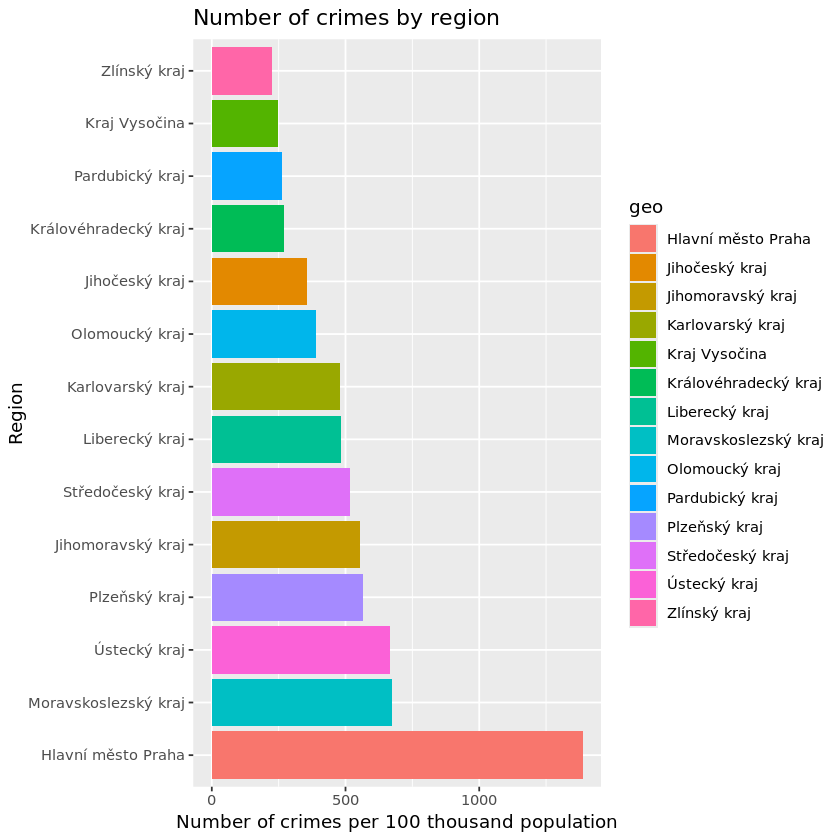

In [23]:
ggplot(df_cz_2021, aes(x = reorder(geo, -values), y = values, fill = geo)) +
  geom_bar(stat = "identity") +
  coord_flip() + # For horizontal bars
  labs(title = "Number of crimes by region",
       x = "Region",
       y = "Number of crimes per 100 thousand population")

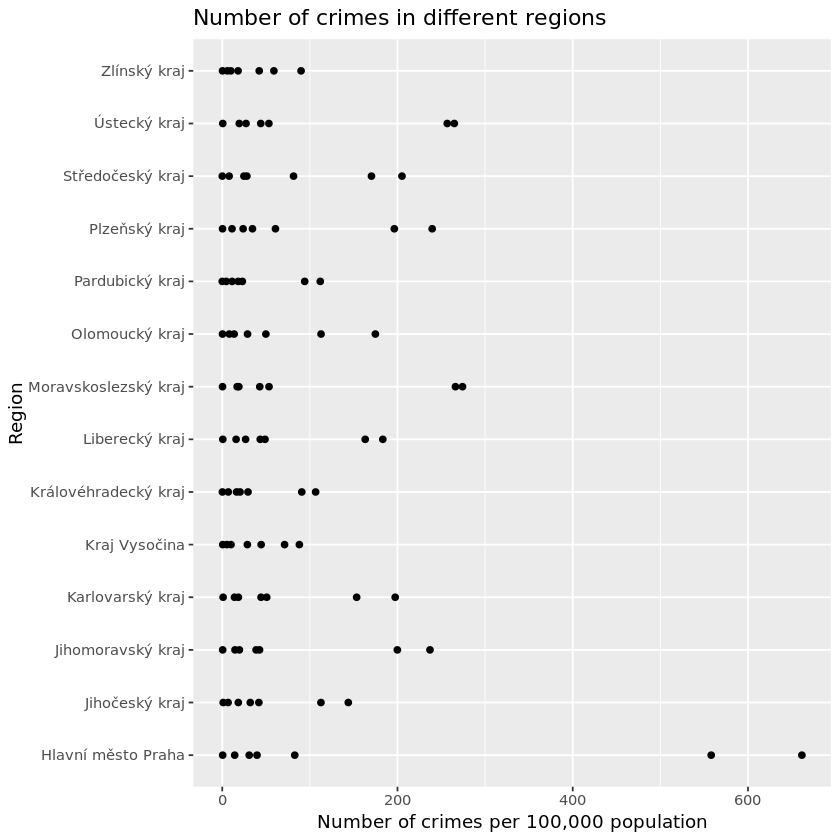

In [24]:
# dot plot
ggplot(df_cz_2021, aes(x = values, y = geo)) +
  geom_point() +
  labs(title = "Number of crimes in different regions",
       x = "Number of crimes per 100,000 population",
       y = "Region")

- Each point corresponds to a certain type of crime and we can see that in certain regions certain types of crime occur much more frequently than in others.

- There are twice as many crimes committed in Prague as in the region in second place. It can be seen that two types of crime are much more common than in all other regions

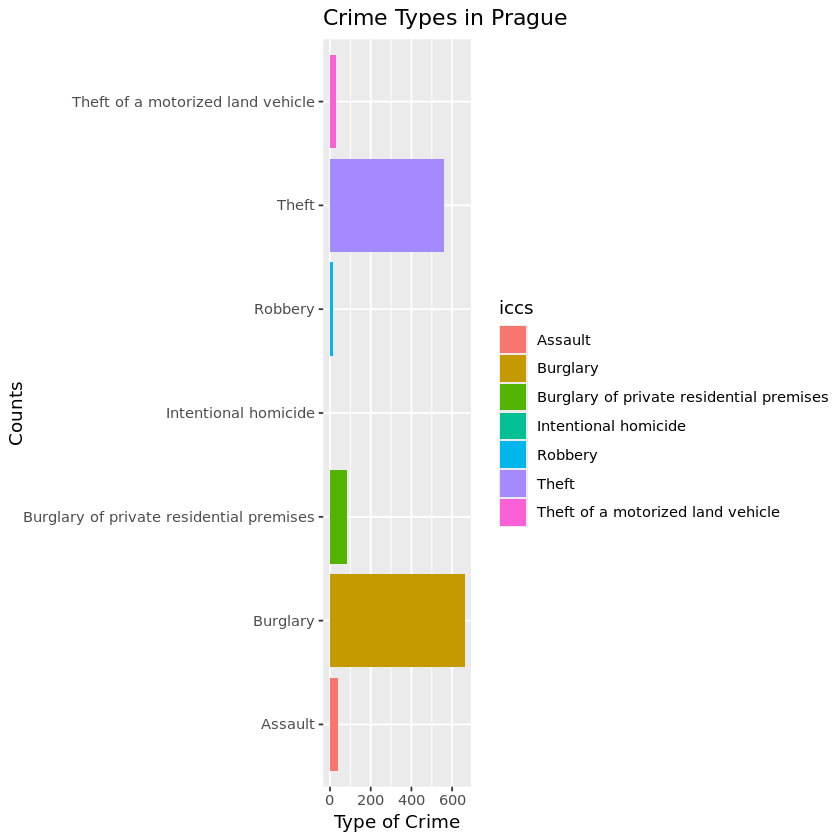

In [25]:
prague_data <- subset(df_cz_2021, geo == "Hlavní město Praha")

# bar plot for Prague 
ggplot(prague_data, aes(x = iccs, y = values, fill = iccs)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +  
  theme(axis.text.y = element_text(angle = 0)) +
  labs(title = "Crime Types in Prague", x = "Counts", y = "Type of Crime")

- The *Theft* and *Burglary* category in Prague is much higher than in other regions

---

# Task 2

As the first step, we will create contingency tables for the number of crimes by region and type of crime.

In [26]:
# create empty matrix with the same number of columns as unique iccs values
cont_table <- matrix(0, nrow = 0, ncol = length(unique(df_cz_2021$iccs)))

# fill the matrix with number of crimes for each region
for (i in unique(df_cz_2021$geo)) {
  cont_table <- rbind(cont_table, i = c(df_cz_2021[df_cz_2021$geo == i,]$values))
  rownames(cont_table)[nrow(cont_table)] <- i
}
colnames(cont_table) <- unique(df_cz_2021$iccs)
addmargins(cont_table)

,Intentional homicide,Assault,Robbery,Burglary,Burglary of private residential premises,Theft,Theft of a motorized land vehicle,Sum
Hlavní město Praha,0.52,39.70,14.23,661.53,82.77,558.02,30.78,1387.55
Středočeský kraj,0.07,28.11,7.87,205.15,81.40,170.31,24.75,517.66
Jihočeský kraj,1.09,41.80,6.68,112.66,32.01,143.88,18.34,356.46
Plzeňský kraj,0.34,34.52,11.17,239.58,60.74,196.43,23.86,566.64
Karlovarský kraj,1.02,44.32,13.98,153.42,50.80,197.40,18.41,479.35
Ústecký kraj,0.61,43.94,19.46,256.80,53.24,264.87,27.17,666.09
Liberecký kraj,0.68,43.39,15.82,163.17,48.82,183.28,26.67,481.83
Královéhradecký kraj,0.18,29.41,6.90,90.78,20.33,106.57,16.34,270.51
Pardubický kraj,0.00,22.95,4.59,94.10,18.17,111.89,11.28,262.98
Kraj Vysočina,0.59,44.41,5.31,71.14,28.69,88.04,10.02,248.20


Here one cell of the table will contain the number of crimes of a specific type in a specific region. The rows of the table will correspond to the regions, and the columns will correspond to the types of crime.
Last row and column will contain the total number of crimes by region and by type of crime, respectively.

Now we can create probability tables for the number of crimes by region and type of crime.

In [27]:
probs = prop.table(cont_table)
addmargins(probs)

,Intentional homicide,Assault,Robbery,Burglary,Burglary of private residential premises,Theft,Theft of a motorized land vehicle,Sum
Hlavní město Praha,7.348182e-05,0.005610055,0.0020108584,0.093481597,0.011696328,0.07885447,0.004349559,0.19607635
Středočeský kraj,9.891784e-06,0.003972258,0.0011121191,0.028989992,0.011502732,0.02406671,0.003497452,0.07315115
Jihočeský kraj,1.540292e-04,0.005906808,0.0009439588,0.015920120,0.004523371,0.02033186,0.002591647,0.05037179
Plzeňský kraj,4.804581e-05,0.004878063,0.0015784461,0.033855337,0.008583242,0.02775776,0.003371685,0.08007258
Karlovarský kraj,1.441374e-04,0.006262912,0.0019755306,0.021679964,0.007178609,0.02789483,0.002601539,0.06773752
Ústecký kraj,8.619983e-05,0.006209214,0.0027499159,0.036288716,0.007523408,0.03742910,0.003839425,0.09412598
Liberecký kraj,9.609161e-05,0.006131493,0.0022355432,0.023057748,0.006898813,0.02589952,0.003768770,0.06808797
Královéhradecký kraj,2.543602e-05,0.004155962,0.0009750473,0.012828231,0.002872857,0.01505953,0.002309025,0.03822609
Pardubický kraj,0.000000e+00,0.003243092,0.0006486184,0.013297384,0.002567624,0.01581131,0.001593990,0.03716202
Kraj Vysočina,8.337361e-05,0.006275630,0.0007503625,0.010052879,0.004054218,0.01244104,0.001415938,0.03507344


In the above table, cell *(i, j)* contains the probability of a crime of type *j* occurring in region *i*. The last row and column will contain the total probability of a crime occurring in a specific region and of a specific type of crime, respectively.

Now we can propose hypotheses that number of crimes of a specific type in a specific region is independent of the region. We are going to use fisher's exact test to test these hypotheses because in some regions the number of crimes of a specific type is very low.
- $H_0$: The number of crimes of a specific type in a specific region is independent of the region.
- $H_A$: The number of crimes of a specific type in a specific region is dependent on the region.

In [28]:
fisher <- fisher.test(cont_table, simulate.p.value = TRUE)
fisher

Warning message in fisher.test(cont_table, simulate.p.value = TRUE):
“'x' has been rounded to integer: Mean relative difference: 0.003309508”



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  cont_table
p-value = 0.0004998
alternative hypothesis: two.sided


As we got p-value less than 0.05, we can reject the null hypothesis and conclude that the number of crimes of a specific type in a specific region is not independent of the region.

---

# Task 3

#### Test 1

As our first test we can test if the mean number of crimes in Czech republic is equal to the mean number of crime in all countries in the dataset. We need to calculate the mean number of crimes in the whole dataset and then use t-test to test the hypothesis. We can use t-test because the number of crimes is a quantitative variable and the number of crimes in the Czech Republic is a random sample from the whole dataset.

In [29]:
# take only the data for 2021
df_2021 <- df[format.Date(df$TIME_PERIOD, "%Y") == "2021", ]
df_2021 <- df_2021[df_2021$unit != "NR",]
df_2021 <- df_2021[grepl("^.{5}$", df_2021$geo),]
df_2021 <- subset(df_2021, select = -c(unit))
df_2021 <- subset(df_2021, select = -c(freq, TIME_PERIOD))
df_2021 <- label_eurostat(df_2021, fix_duplicated = TRUE)
head(df_2021)

Labels for geo includes duplicated labels in the Eurostat dictionary. Codes have been added as a prefix for duplicated.
Modified labels are: DKZZZ Extra-Regio NUTS 3, EEZZZ Extra-Regio NUTS 3, ESZZZ Extra-Regio NUTS 3, ITZZZ Extra-Regio NUTS 3, LVZZZ Extra-Regio NUTS 3, NLZZZ Extra-Regio NUTS 3, PTZZZ Extra-Regio NUTS 3, SIZZZ Extra-Regio NUTS 3, FIZZZ Extra-Regio NUTS 3, SEZZZ Extra-Regio NUTS 3



iccs,geo,values
<chr>,<chr>,<dbl>
Intentional homicide,Dibër,3.52
Intentional homicide,Durrës,1.03
Intentional homicide,Kukës,1.34
Intentional homicide,Lezhë,3.31
Intentional homicide,Shkodër,4.56
Intentional homicide,Elbasan,3.38


In [30]:
# sums for subcategories
m_theft_sum <- aggregate(values ~ geo, data = df_2021[df_2021$iccs == 'Theft of a motorized land vehicle',], sum)
r_burglary_sum <- aggregate(values ~ geo, data = df_2021[df_2021$iccs == 'Burglary of private residential premises',], sum)

In [31]:
for(i in 1:nrow(df_2021)) {
  if(df_2021$iccs[i] == 'Theft' && df_2021$geo[i] %in% m_theft_sum$geo) {
    df_2021$values[i] <- df_2021$values[i] - m_theft_sum$values[m_theft_sum$geo == df_2021$geo[i]]
  } else if(df_2021$iccs[i] == 'Burglary' && df_2021$geo[i] %in% r_burglary_sum$geo) {
    df_2021$values[i] <- df_2021$values[i] - r_burglary_sum$values[r_burglary_sum$geo == df_2021$geo[i]]
  }
}

In [32]:
# count the number of crimes for each region
crimes_by_region <- aggregate(values ~ geo, data = df_2021, FUN = sum)
head(crimes_by_region)

,geo,values
,<chr>,<dbl>
1,A Coruña,521.50
2,Aargau,1396.11
3,Achaia,749.54
4,Achterhoek,938.50
5,Adana,819.62
6,Adıyaman,285.23


In [33]:
summary(crimes_by_region$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.05  459.71  721.58  997.36 1261.32 5931.33 

As we see, the mean value of the number of crimes in the whole dataset is **1113.6**. We can now test the hypothesis that the mean number of crimes in the Czech Republic is equal to that value. That is the null hypothesis. The alternative hypothesis is that the mean number of crimes in the Czech Republic is different from that value. We can use t-test to test this hypothesis.
- $H_0$: The mean number of crimes in the Czech Republic is equal to the mean number of crimes in all countries in the dataset.
- $H_A$: The mean number of crimes in the Czech Republic is different from the mean number of crimes in all countries in the dataset.

In [34]:
# we also need to have sums for each czech region
cz_by_region <- aggregate(values ~ geo, data = df_cz_2021, FUN = sum)
head(cz_by_region)

,geo,values
,<chr>,<dbl>
1,Hlavní město Praha,1387.55
2,Jihočeský kraj,356.46
3,Jihomoravský kraj,552.82
4,Karlovarský kraj,479.35
5,Kraj Vysočina,248.20
6,Královéhradecký kraj,270.51


In [35]:
t.test(cz_by_region$values, mu = 1113.6)


	One Sample t-test

data:  cz_by_region$values
t = -7.7044, df = 13, p-value = 3.368e-06
alternative hypothesis: true mean is not equal to 1113.6
95 percent confidence interval:
 334.9467 675.9933
sample estimates:
mean of x 
   505.47 


As our p-value is not less than 0.05, we cannot reject the null hypothesis that the mean number of crimes in the Czech Republic is equal to the mean number of crimes in the whole dataset.

#### Test 2

First, we obtain from the dataset data for Slovakia similar to the Czech data, i.e., the sum of the number of crimes per hundred thousand inhabitants for each region for the year 2021

In [36]:
df_sk <- df[grepl("SK", df$geo),]
df_sk <- df_sk[grepl("^SK0\\d{2}$", df_sk$geo), ]
df_sk_2021 <- df_sk[format.Date(df_sk$TIME_PERIOD, "%Y") == "2021",]
df_sk_2021 <- label_eurostat(df_sk_2021, fix_duplicated = TRUE)
df_sk_2021 <- subset(df_sk_2021, select = -c(freq, TIME_PERIOD))
df_sk_2021 <- df_sk_2021[df_sk_2021$unit != "Number",]
df_sk_2021 <- subset(df_sk_2021, select = -c(unit))

sk_by_region <- aggregate(values ~ geo, data = df_sk_2021, FUN = sum)
head(sk_by_region)

,geo,values
,<chr>,<dbl>
1,Banskobystrický kraj,275.23
2,Bratislavský kraj,551.98
3,Košický kraj,342.11
4,Nitriansky kraj,216.53
5,Prešovský kraj,213.16
6,Trenčiansky kraj,191.56


As a second test we will conduct the Shapiro test for the data of Czech Republic and Slovakia, where
- $H_0$: The data is normally distributed.
- $H_A$: The data is not normally distributed.

In [37]:
shapiro.test(cz_by_region$values)


	Shapiro-Wilk normality test

data:  cz_by_region$values
W = 0.77507, p-value = 0.002495


The p-value is 0.002495, which is significantly below the common alpha level of 0.05. This result leads us to reject the null hypothesis that the data is normally distributed.

In [38]:
shapiro.test(sk_by_region$values)


	Shapiro-Wilk normality test

data:  sk_by_region$values
W = 0.82174, p-value = 0.04867


The p-value is 0.04867. This value is less than 0.05, indicating that there is sufficient evidence to reject the null hypothesis that the distribution is normal.  
Despite this, the value is quite close to 0.05. Therefore, we could further examine the QQ plot to visually assess the distribution of the data. If the QQ plot shows a significant deviation from the line of normality, this would additionally confirm that the data does not follow a normal distribution, which would support the use of non-parametric tests for further analysison)

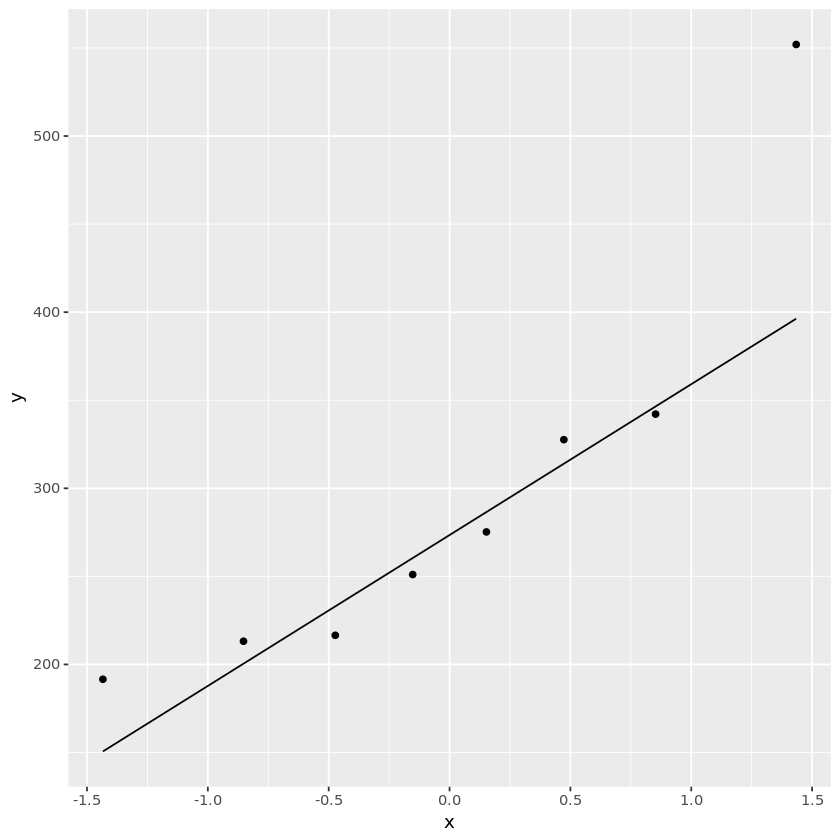

In [39]:
plot <- ggplot(sk_by_region, aes(sample = values)) +
        stat_qq(distribution = qnorm, show.legend = T) +
        stat_qq_line(distribution = qnorm, show.legend = F)

plot

Upon examining the QQ plot for the Slovak data, it is observed that some points indeed lie far from the straight line, which suggests deviations from normality. Given this visual evidence along with the inherent variability of regional crime data, we will consider that the data for Slovakia is also not normally distributed. This conclusion, combined with the results of the Shapiro-Wilk test, supports the decision to use non-parametric methods for further statistical analysis.

#### Test 3

We will now perform the Wilcoxon rank-sum test to compare the median values of crime counts between the Czech and Slovak regions. This non-parametric test is chosen due to the non-normal distribution of our data, as indicated by the Shapiro-Wilk test and the QQ plot.  

The hypotheses for the Wilcoxon test are:
- $H_0$: The median values of crime counts are the same across the Czech and Slovak regions.  
- $H_A$: The median values of crime counts differ between the Czech and Slovak regions.

In [40]:
wilcox.test(cz_by_region$values, sk_by_region$values)


	Wilcoxon rank sum exact test

data:  cz_by_region$values and sk_by_region$values
W = 89, p-value = 0.02402
alternative hypothesis: true location shift is not equal to 0


The p-value is 0.02402, which is below the conventional alpha level of 0.05. This means that we have enough evidence to reject the null hypothesis. Therefore, we conclude that statistically significant differences in median crime rates between the Czech and Slovak regions exist.